# Story and plots for Poster/Paper on resolution dependece of cold pool driven triggering.
Assumption: cold pools are also responsible for a lack of convection organization.
Research questions: 
1) Are cold pools related to a lack of late afternoon convection?
2) What processes/aspects are missing in km-scale models that cause this lack of late afternoon convection?

In [1]:
from enstools.io import read
from enstools.plot import contour
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import pandas as pd
import xarray as xr
import numpy as np
import dask
import seaborn as sns
import logging
from enstools.io import read
from sklearn.cluster import KMeans
homedir = '/home/m/M.Hirt/'
outdir_data = homedir + 'Cold_Pools/Mistral_work/Data/cp_characteristics_fixed2019/'
plt.style.use(['seaborn-deep', '/home/m/M.Hirt/poster.mplstyle'])
%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.INFO)
grid_ordered = ['625m', '312m', '156m']
mask_order = ['no_coldpool','cp_mask','cp_edges']


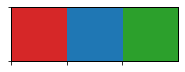

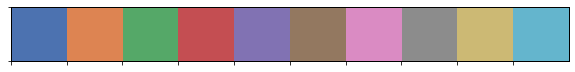

In [2]:
current_palette = sns.color_palette('tab10')
grid_colors =[ current_palette[i] for i in [3,0,2]]
secondary_colors= sns.color_palette('deep')#[sns.color_palette('deep')[i] for i in [3,9,8,2,1,0,4,6,7]]
sns.palplot(grid_colors)
sns.palplot(secondary_colors)

In [3]:
# functions etc
# '20140815' : don't use this day for now because 'intensity', Buoyncay_sfc/cptop and CAPE CIN are missing, as well as because this day has only 5min data 
def load_data(characteristics='cp_aggregates', dates = ['20150705', '20160529', '20160606', '20160801'],
              doms = ['DOM01', 'DOM02','DOM03'], rename_doms=True):
    ci_mask = 'ci_mask_clw_mlvi_60-110_2.0_*'
    cp_edges = 'cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70'
    ds2=[]
    for date in dates:
        ds0=[]
        for dom in doms:
            if characteristics=='cp_aggregates':
                cp_aggregates_fname = '%s%s/%s/cold_pool_characteristics/%s/%s/%s_height131_%s_%s.nc'%(
                    outdir_data, date, dom, ci_mask , cp_edges, characteristics, dom, date)
            else:
                cp_aggregates_fname = '%s%s/%s/cold_pool_characteristics/%s/%s/%s_%s_%s.nc'%(outdir_data, date, dom, ci_mask , cp_edges,characteristics, dom, date)
            logging.debug(cp_aggregates_fname)
            try:
                cp_aggregates_fname = glob.glob(cp_aggregates_fname)[0]
            except:
                logging.warning('cp_aggregates_fname is empty for %s, %s!'%(date, dom))
                continue
            logging.debug(cp_aggregates_fname)
            egg = read(cp_aggregates_fname).compute()
            try:
                egg['dom']=dom
            except:
                pass
            egg = egg.set_coords('dom')
            if date=='20140815':
                egg = egg.resample(time='5min').interpolate('linear')
            if 'cp_tracks' in egg.mask.values:
                masks = list(egg.mask.values)
                masks[masks.index('cp_tracks')]='cp_mask'
                egg.mask.values = masks
            if characteristics =='cp_aggregates':
                if 'cape_ml' not in egg: egg['cape_ml']=np.nan
                if 'cin_ml' not in egg: egg['cin_ml']=np.nan
                if 'lon' not in egg: egg['lon']=np.nan
                if 'intensity' not in egg: egg['intensity']=np.nan
                if 'buoyancy_CPtop' not in egg: egg['buoyancy_CPtop']=np.nan
            ds0.append(egg)
        ds=xr.auto_combine(ds0, concat_dim ='dom')
        ds2.append(ds)
    ds=xr.auto_combine(ds2,concat_dim='time')
    ds=ds.compute()
    if characteristics=='cp_aggregates':
        ds['p_ci']= ds.n_triggering/ds.n_gridpoints
        ds=ds.where(np.isnan(ds.pt_rho_pert)==False)
    ds['date']=ds.time.copy()
    ds['date'].values = pd.to_datetime(ds.time.values).date.astype('str')
    ds['time_hhmm'] = ds.time.copy(deep=True)
    ds['time_hhmm'].values = pd.to_datetime(ds.time.values).time#.astype('str')
    if rename_doms: 
        if ds.dom.values[0] =='DOM01':
            ds['dom']= ['625m', '312m', '156m']
        elif ds.dom.values[0] =='DOM03':
            ds['dom']= [ '156m', '312m', '625m']
        ds=ds.rename(dict(dom='grid_size')).sortby('grid_size')
    return ds



In [4]:
def load_data_tracks_selected(characteristics='cp_aggregates', dates = ['20140815','20150705', '20160529', '20160606', '20160801'],
              doms = ['DOM01', 'DOM02','DOM03'], rename_doms=True):
    ci_mask = 'ci_mask_clw_mlvi_60-110_2.0_*'
    cp_edges = 'cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70'
    ds2=[]
    outdir_data = homedir + 'Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/'
    for date in dates:
        ds0=[]
        for dom in doms:
            if characteristics=='prec':
                cp_aggregates_fname = '%s%s/%s/cold_pool_characteristics/%s/%s/prec_%s_%s.nc'%(outdir_data, date, dom, ci_mask , cp_edges, dom, date)
            else:
                cp_aggregates_fname =outdir_data + date + '/'+ dom+ '/tracked_cold_pool_characteristics/*/*/'+characteristics +'__height*' 
            logging.debug(cp_aggregates_fname)
            try:
                cp_aggregates_fname = glob.glob(cp_aggregates_fname)[0]
            except:
                logging.warning('cp_aggregates_fname is empty for %s, %s!'%(date, dom))
                continue
            print(cp_aggregates_fname)
            logging.debug(cp_aggregates_fname)
            #egg = read(cp_aggregates_fname).compute()
            egg = xr.open_dataset(cp_aggregates_fname)
            egg['dom']=dom
            egg = egg.set_coords('dom')
            if date=='20140815':
                egg = egg.resample(time='5min').interpolate('linear')
            if 'cp_tracks' in egg.mask.values:
                masks = list(egg.mask.values)
                masks[masks.index('cp_tracks')]='cp_mask'
                egg.mask.values = masks
            logging.debug(egg)
            egg = egg[['intensity','buoyancy_CPtop', 'n_triggering','n_gridpoints', 'TOT_PREC', #'hus', 'hdiv_ll', 'theta_v', 
                       'wa','massflux_u','massflux_d', 'time','cp_index','mask','pctl_stats',# 'pt_rho_pert',  'theta_CPtop',  'hus_CPtop'
                      ]]
            egg = egg.sel(pctl_stats=['mean', 'sum', '5pctl','95pctl']).persist()
            ds_sel=xr.Dataset()
            ds_sel['intensity_mean_cp'] = egg['intensity'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['intensity_sum_cp'] = egg['intensity'].sel(pctl_stats='sum', mask = 'cp_mask')
            ds_sel['buoyancy_CPtop_mean_cp'] = egg['buoyancy_CPtop'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['n_gridpoints_cp'] = egg['n_gridpoints'].sel( mask = 'cp_mask')
            ds_sel['n_triggering_cp'] = egg['n_triggering'].sel( mask = 'cp_mask')
            ds_sel['TOT_PREC_mean_cp'] = egg['TOT_PREC'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['TOT_PREC_sum_cp'] = egg['TOT_PREC'].sel(pctl_stats='sum', mask = 'cp_mask')
            ds_sel['massflux_d_mean_cp'] = egg['massflux_d'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['massflux_d_sum_cp'] = egg['massflux_d'].sel(pctl_stats='sum', mask = 'cp_mask')
            ds_sel['wa_5_cp'] = egg['wa'].sel(pctl_stats='5pctl', mask = 'cp_mask')
            
            ds_sel['n_gridpoints_cpe'] = egg['n_gridpoints'].sel( mask = 'cp_edges')
            ds_sel['n_triggering_cpe'] = egg['n_triggering'].sel( mask = 'cp_edges')
            ds_sel['wa_95_cpe'] = egg['wa'].sel(pctl_stats='95pctl', mask = 'cp_edges')
            ds_sel['massflux_u_mean_cpe'] = egg['massflux_u'].sel(pctl_stats='mean', mask = 'cp_edges')
            ds_sel['massflux_u_sum_cpe'] = egg['massflux_u'].sel(pctl_stats='sum', mask = 'cp_edges')
            ds_sel['buoyancy_CPtop_95_cpe'] = egg['buoyancy_CPtop'].sel(pctl_stats='95pctl', mask = 'cp_edges')
            
            
            # read in track initiation/determination file:
            if characteristics=='cp_aggregates2': 
                fname = glob.glob("/home/m/M.Hirt/Cold_Pools/Mistral_work_sophia/cold_pools/%s-*/irt_tracks_tab_%s*%s*.txt"%(date,date,dom))
                track_type = pd.read_csv(fname[0], header = None,delim_whitespace=True, escapechar='*')
                del track_type[0]; 
                track_type = track_type.rename(columns={1:'cp_index',2: 'starting_time_step',3: 'track_duration',4:'track_initiation_type',5:'track_determination_type'})#;
                track_type['cp_index'] = track_type.cp_index#-1
                track_type =track_type.set_index('cp_index');
                ds_sel['track_initiation_type'] =track_type.track_initiation_type.to_xarray()
                ds_sel['track_determination_type'] =track_type.track_determination_type.to_xarray()
                ds_sel['track_duration'] =track_type.track_duration.to_xarray() 
                if date =="20140815":
                    ds_sel['track_duration'] =track_type.track_duration.to_xarray()*15
                else:
                    ds_sel['track_duration'] =track_type.track_duration.to_xarray()*5

            if ds0!=[]:
                ds_sel['cp_index'] = ds_sel.cp_index + ds0[-1].cp_index.max()+1


            ds0.append(ds_sel.persist())
        ds=xr.concat(ds0, dim ='dom')
        if ds2!=[]:
            ds['cp_index'] = ds.cp_index + ds2[-1].cp_index.max()+1
        ds2.append(ds)
    ds=xr.concat(ds2,dim='time')
    ds['p_ci_cp']= ds.n_triggering_cp/ds.n_gridpoints_cp
    ds['p_ci_cpe']= ds.n_triggering_cpe/ds.n_gridpoints_cpe
    ds=ds.where(np.isnan(ds.intensity_mean_cp)==False)

    ds['date']=ds.time.copy()
    ds['date'].values = pd.to_datetime(ds.time.values).date.astype('str')
    ds['time_hhmm'] = ds.time.copy(deep=True)
    ds['time_hhmm'].values = pd.to_datetime(ds.time.values).time#.astype('str')
    if rename_doms: 
        ds['dom']= ['625m', '312m', '156m']
        ds=ds.rename(dict(dom='grid_size')).sortby('grid_size')
        
    return ds


## RQ1) Are cold pools related to a lack of late afternoon convection?



## Precipitation

In [5]:
logger.setLevel(logging.INFO)
ds = load_data(characteristics='prec_166_96')
ds['prec_cp'] = ds.prec_sum.sel(mask='cp_mask') + ds.prec_sum.sel(mask='cp_edges')
ds['prec_tot'] = ds.prec_sum.sel(mask=['cp_mask','cp_edges','no_coldpool']).sum('mask')
df= ds.to_dataframe().reset_index()


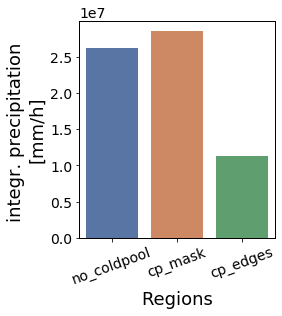

In [6]:
#sns.catplot(data=df[df['mask'] !='cp_gradient'], x='mask', y='prec_sum', hue='grid_size',
#            kind='bar', hue_order=grid_ordered)
plt.figure(figsize=[3.5,4])
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='mask', y='prec_sum', estimator=np.sum,
            palette=secondary_colors, order = mask_order, capsize=.2,# col = 'date',
            dodge=False, ci =None)
plt.xticks(rotation=20)
plt.ylabel('integr. precipitation \n[mm/h]')
plt.xlabel('Regions')
plt.savefig('../Figures/prec_sum_dom03.pdf')

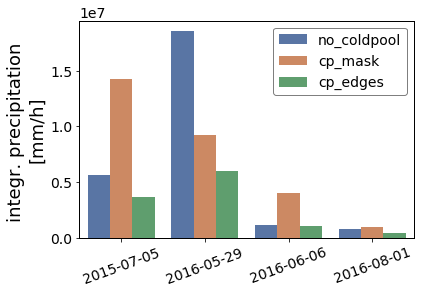

In [7]:
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='date', y='prec_sum', estimator=np.sum,
            palette=secondary_colors, capsize=.2, hue = 'mask', hue_order = mask_order, ci = None)
plt.xticks(rotation=20)
plt.ylabel('integr. precipitation \n[mm/h]')
plt.xlabel('')

leg = plt.gca().legend(loc='upper right')
leg.get_frame().set_alpha(0.5)
plt.savefig('../Figures/prec_sum_dom03_dates.pdf')


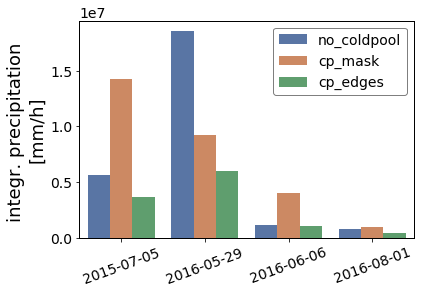

In [8]:
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='date', y='prec_sum', estimator=np.sum,
            palette=secondary_colors, capsize=.2, hue = 'mask', hue_order = mask_order, ci = None)
plt.xticks(rotation=20)
plt.ylabel('integr. precipitation \n[mm/h]')
plt.xlabel('')

leg = plt.gca().legend(loc='upper right')
leg.get_frame().set_alpha(0.5)
plt.savefig('../Figures/prec_sum_dom03_dates.pdf')



/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Regions')

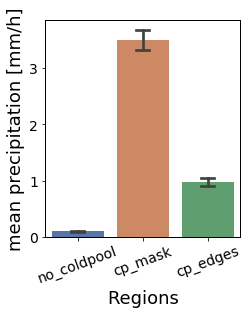

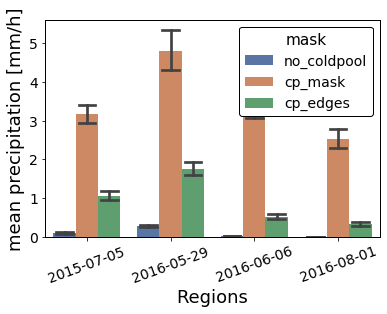

In [9]:

plt.figure(figsize=[3.5,4])
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='mask', y='prec_mean', #estimator=np.sum,
            palette=secondary_colors, order = mask_order,# col = 'date',
            dodge=False, capsize=.2)
plt.xticks(rotation=20)
plt.ylabel('mean precipitation [mm/h]')
plt.xlabel('Regions')

# ------------------------------------------
plt.figure()
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='date', y='prec_mean', #estimator=np.sum,
            palette=secondary_colors, hue_order = mask_order, hue ='mask', 
            dodge=True, capsize=.2)
plt.xticks(rotation=20)
plt.ylabel('mean precipitation [mm/h]')
plt.xlabel('Regions')


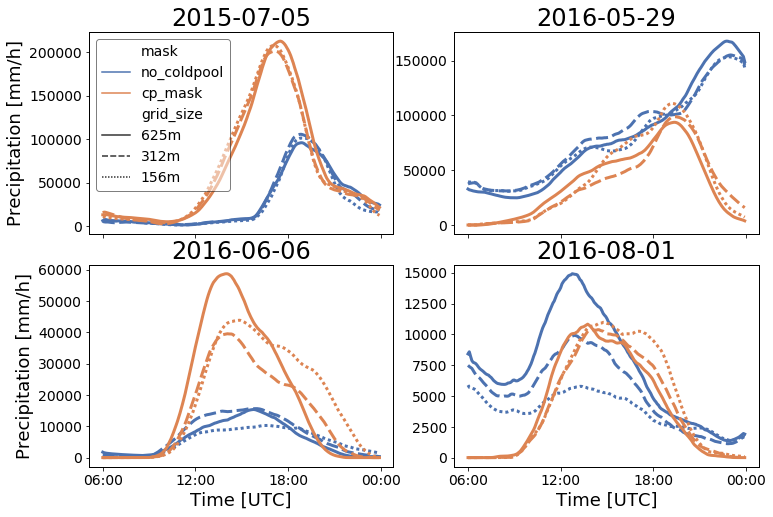

In [10]:
df['Time_h'] = df.time.dt.hour//1*1
egg = df.set_index(['time_hhmm','grid_size', 'mask', 'date']).unstack(
    ['grid_size','mask','date'])[['prec_sum']].rolling(36, min_periods=1).mean().stack(
    ['grid_size','mask', 'date']).reset_index()
fig, axs= plt.subplots(nrows=2,ncols=2, figsize=[12,8], sharex=True)
use_leg=['brief', False, False, False]
axs=axs.ravel()
for i,date in enumerate(egg.date.unique()):
    sns.lineplot(data=egg[(egg['mask'] !='cp_gradient')&  (egg['mask'] !='cp_edges') & (egg.date ==date) ], x='time_hhmm', 
                legend=use_leg[i], palette=secondary_colors[:2], hue_order = ['no_coldpool', 'cp_mask'],
                y='prec_sum', hue='mask', style= 'grid_size', ax=axs[i], style_order = grid_ordered,
                ci=None, linewidth=3)#, hue_order=grid_ordered)
    axs[i].set_title(date)
leg= axs[0].legend()
leg.get_frame().set_alpha(0.5)

axs[0].set_ylabel('Precipitation [mm/h]')
axs[1].set_ylabel('')
axs[2].set_ylabel('Precipitation [mm/h]')
axs[3].set_ylabel('')
axs[2].set_xlabel('Time [UTC]')
axs[3].set_xlabel('Time [UTC]')

ticks = np.arange(6,25,6)*3600
axs[2].set_xticks( ticks )

fig.subplots_adjust(hspace=.15, wspace=.2)
fig.savefig('../Figures/prec_sum_timeseries_single_days.pdf')

## Triggering

In [11]:
logger.setLevel(logging.INFO)
ds = load_data(characteristics='P_ci_166_96', rename_doms=True)


In [12]:
ds['P_ci2']= ds.N_ci/ds.N_ref
ds['N_ci_ratio'] = ds.N_ci /ds.N_ci.sel(mask=['cp_mask','cp_edges','no_coldpool']).sum(['mask'])
df= ds.to_dataframe().reset_index()


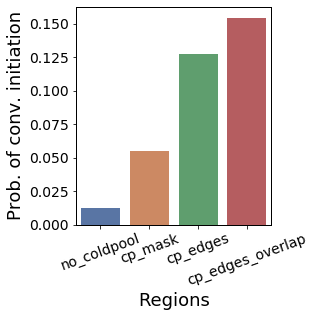

In [13]:
plt.figure(figsize=[3.5,4])
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='mask', y='P_ci',
            palette=secondary_colors, capsize=.2, ci=None, estimator = np.median,
            dodge=False)
plt.xticks(rotation=20)
plt.ylabel('Prob. of conv. initiation')
plt.xlabel('Regions')
plt.savefig('../Figures/PCI_dom03.pdf')

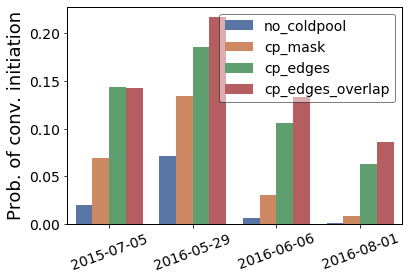

In [14]:
#plt.figure(figsize=[3.5,4])
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='date', y='P_ci',
            palette=secondary_colors, capsize=.2, hue = 'mask', ci = None, estimator = np.median,
            dodge=True)
plt.xticks(rotation=20)
leg = plt.gca().legend(loc='upper right')
leg.get_frame().set_alpha(0.5)
plt.ylabel('Prob. of conv. initiation')
plt.xlabel('')
plt.savefig('../Figures/PCI_dom03_dates.pdf')



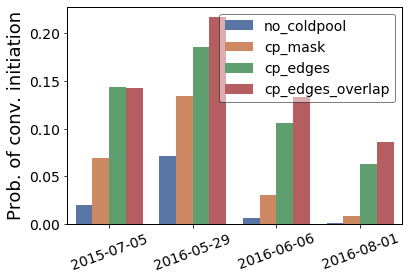

In [15]:
#plt.figure(figsize=[3.5,4])
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='date', y='P_ci',
            palette=secondary_colors, capsize=.2, hue = 'mask', ci = None, estimator = np.median,
            dodge=True)
plt.xticks(rotation=20)
leg = plt.gca().legend(loc='upper right')
leg.get_frame().set_alpha(0.5)
plt.ylabel('Prob. of conv. initiation')
plt.xlabel('')
plt.savefig('../Figures/PCI_dom03_dates.pdf')


/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


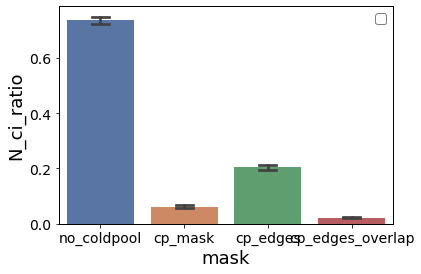

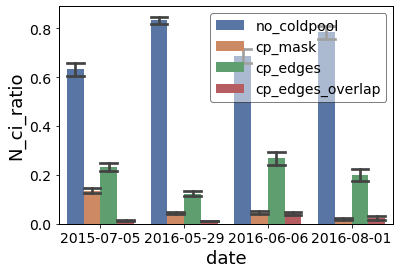

In [16]:
sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='mask', y='N_ci_ratio',
            palette=secondary_colors, capsize=.2,# hue = 'mask',
            dodge=True)
leg = plt.gca().legend(loc='upper right')
leg.get_frame().set_alpha(0.5)

#---------------------------------------------------------
plt.figure()

sns.barplot(data=df[(df['mask'] !='cp_gradient') & (df['grid_size']=='156m')], x='date', y='N_ci_ratio',
            palette=secondary_colors, capsize=.2, hue = 'mask',
            dodge=True)
leg = plt.gca().legend(loc='upper right')
leg.get_frame().set_alpha(0.5)



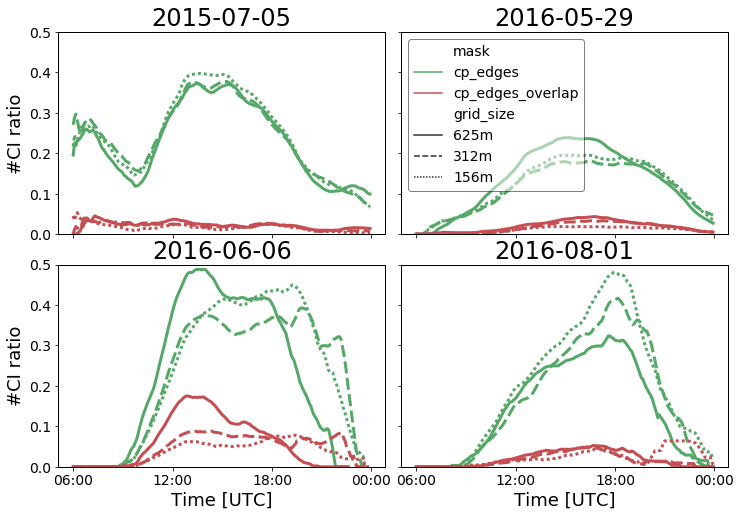

In [17]:

egg = df.set_index(['time_hhmm','grid_size', 'mask', 'date']).unstack(
    ['grid_size','mask','date'])[['N_ci_ratio']].rolling(36, min_periods=1).mean().stack(
    ['grid_size','mask', 'date']).reset_index()
fig, axs= plt.subplots(nrows=2,ncols=2, figsize=[12,8], sharex=True, sharey=True)
use_leg=[False,'brief', False, False]

axs=axs.ravel()
for i,date in enumerate(['2015-07-05', '2016-05-29', '2016-06-06', '2016-08-01']):
    sns.lineplot(data=egg[((egg['mask'] =='cp_edges') | (egg['mask'] =='cp_edges_overlap')) & (egg.date==date)], x='time_hhmm', 
                legend=use_leg[i], palette=secondary_colors[2:4], #hue_order = ['no_coldpool', 'cp_mask'],
                y='N_ci_ratio', hue='mask', style= 'grid_size', ax=axs[i], style_order = grid_ordered, 
                ci=None, linewidth=3)#, hue_order=grid_ordered)
    axs[i].set_ylim([0,0.5])
    #if i!=0:
    #    axs[i].set_ylabel('')
    axs[i].set_title(date)
leg= axs[1].legend()
leg.get_frame().set_alpha(0.5)
axs[2].set_xlabel('Time [UTC]')
axs[3].set_xlabel('Time [UTC]')
axs[0].set_ylabel('#CI ratio')
axs[2].set_ylabel('#CI ratio')

ticks = np.arange(6,25,6)*3600
axs[2].set_xticks( ticks )

fig.subplots_adjust(hspace=.15, wspace=.05)
fig.savefig('../Figures/n_ci_ratio_edges_diurnal_cycle_days.pdf')

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 <a list of 6 Text xticklabel objects>)

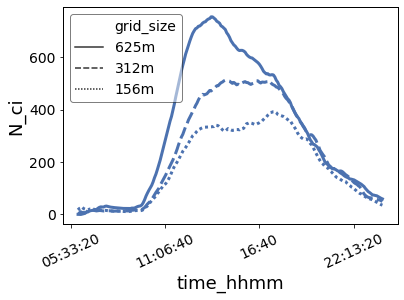

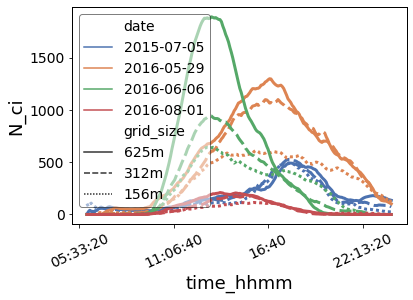

In [18]:
egg = df.set_index(['time_hhmm','grid_size', 'mask', 'date']).unstack(
    ['grid_size','mask','date'])[['N_ci']].rolling(36, min_periods=1).mean().stack(
    ['grid_size','mask', 'date']).reset_index()
egg
egg['forcing_type'] = egg.date.copy()
egg.loc[egg.date=='2015-07-05','forcing_type']='strong forcing'
egg.loc[egg.date=='2016-05-29','forcing_type']='strong forcing'
egg.loc[egg.date=='2016-06-06','forcing_type']='weak forcing'
egg.loc[egg.date=='2016-08-01','forcing_type']='weak forcing'
# ---------------------------------------
sns.lineplot(data=egg[(egg['mask'] =='cp_edges_overlap') ], x = 'time_hhmm', y = 'N_ci',
             style = 'grid_size', 
             linewidth=3, palette = secondary_colors[:2], style_order = grid_ordered, ci = None)
leg = plt.gca().legend()#bbox_to_anchor=(1.1, 1.05))
leg.get_frame().set_alpha(0.5)

plt.xticks(rotation=25)

# ---------------------------------------
plt.figure()
sns.lineplot(data=egg[(egg['mask'] =='cp_edges_overlap') ], x = 'time_hhmm', y = 'N_ci',
             hue = 'date', style = 'grid_size', 
             linewidth=3, palette = secondary_colors[:4], style_order = grid_ordered, ci = None)
leg = plt.gca().legend()#bbox_to_anchor=(1.1, 1.05))
leg.get_frame().set_alpha(0.5)

plt.xticks(rotation=25)



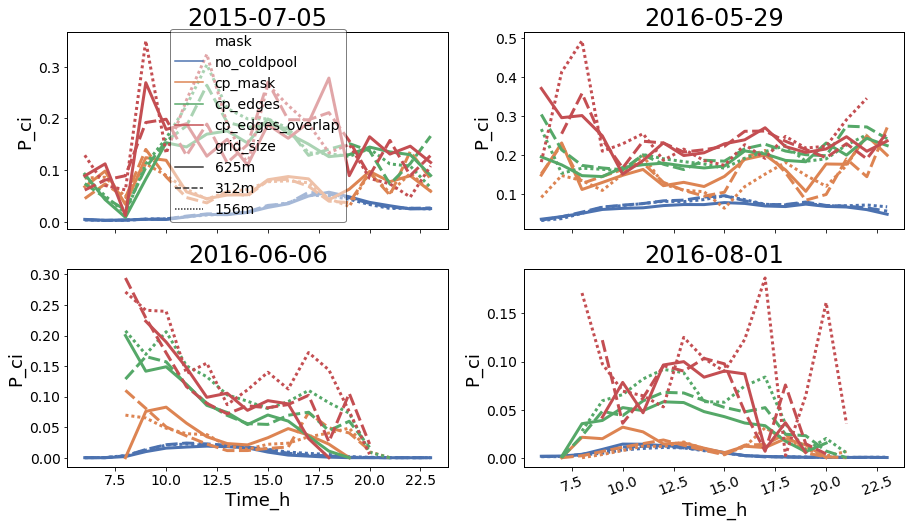

In [20]:
df['Time_h'] = (df.time.dt.hour//1*1).astype(int)
fig, axs= plt.subplots(nrows=2,ncols=2, figsize=[15,8], sharex=True)
axs=axs.ravel()
use_leg=['brief', False, False, False]
for i,date in enumerate(df.date.unique()):
    sns.lineplot(data=df[ (df['mask'] != 'cp_gradient') & (df.date ==date) ], x='Time_h', 
                legend=use_leg[i],
                y='P_ci', hue='mask', style= 'grid_size', ax=axs[i], style_order = grid_ordered, palette=secondary_colors[:4],
                ci=None, linewidth=3)#, hue_order=grid_ordered)
    axs[i].set_title(date)
    #if i!=0:
    #    axs[i].set_ylabel('')
leg= axs[0].legend()
leg.get_frame().set_alpha(0.5)
plt.xticks(rotation=20)
fig.savefig('../Figures/P_ci_diurnal_cycle_each_day.pdf')

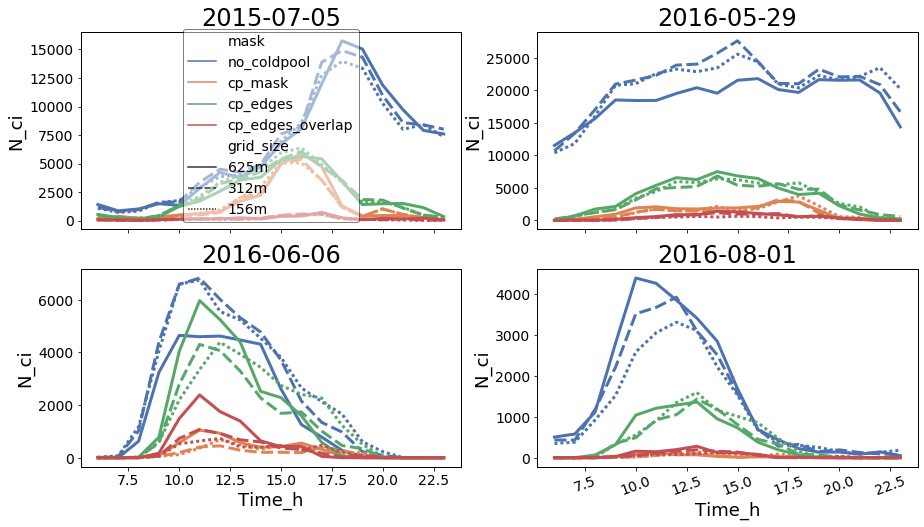

In [22]:
df['Time_h'] = df.time.dt.hour//1*1
fig, axs= plt.subplots(nrows=2,ncols=2, figsize=[15,8], sharex=True)
axs=axs.ravel()
use_leg=['brief', False, False, False]
for i,date in enumerate(df.date.unique()):
    sns.lineplot(data=df[(df['mask']!= 'cp_gradient') & (df.date ==date) ], x='Time_h', 
                legend=use_leg[i],
                y='N_ci', hue='mask', style= 'grid_size', ax=axs[i], style_order = grid_ordered,palette=secondary_colors[0:4],
                ci=None, linewidth=3)#, hue_order=grid_ordered)
    #if i!=0:
    #    axs[i].set_ylabel('')
    axs[i].set_title(date)
leg= axs[0].legend()
leg.get_frame().set_alpha(0.5)
plt.xticks(rotation=20)
fig.savefig('../Figures/N_ci_diurnal_cycle_each_day.pdf')

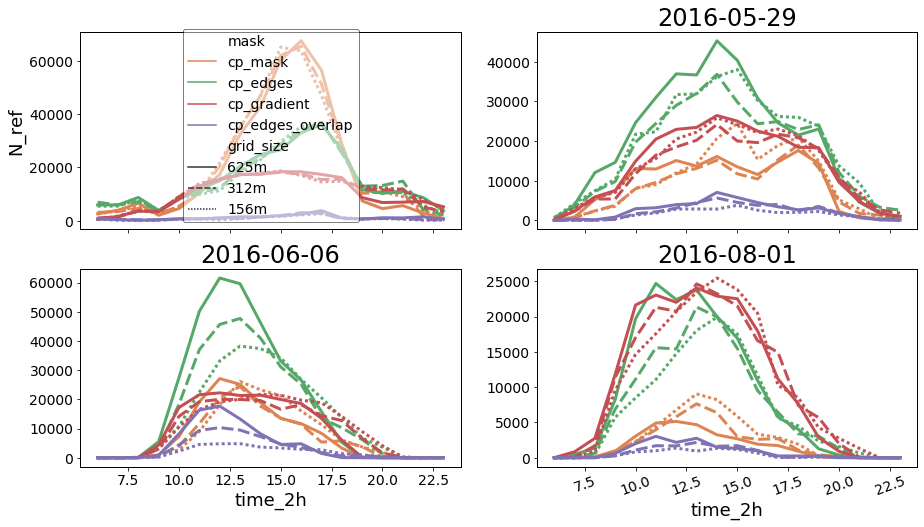

In [23]:
df['time_2h'] = df.time.dt.hour//1*1
fig, axs= plt.subplots(nrows=2,ncols=2, figsize=[15,8], sharex=True)
axs=axs.ravel()
use_leg=['brief', False, False, False]
for i,date in enumerate(df.date.unique()):
    sns.lineplot(data=df[(df['mask']!= 'no_coldpool') & (df.date ==date) ], x='time_2h', 
                legend=use_leg[i],
                y='N_ref', hue='mask', style= 'grid_size', ax=axs[i], style_order = grid_ordered,palette=secondary_colors[1:5],
                ci=None, linewidth=3)#, hue_order=grid_ordered)
    if i!=0:
        axs[i].set_ylabel('')
        axs[i].set_title(date)
leg= axs[0].legend()
leg.get_frame().set_alpha(0.5)
plt.xticks(rotation=20)
fig.savefig('../Figures/N_ref_diurnal_cycle_each_day.pdf')

## RQ2) What processes/aspects are missing in km-scale models that cause this lack of late afternoon convection?

### A) General differences between resolutions

In [26]:
def set_variables_for_tracks(ds):
    age = ds.time.where(xr.ufuncs.isnan(ds.intensity_mean_cp) == False).compute()
    start = age.min(dim='time')
    age = (age-start).astype('timedelta64[m]')
    age = age/ np.timedelta64(60,'s') 
    ds['age']=age
    ds['age_max'] = age.max('time')
    ds['age_max']= ds.age.max('time')
    #ds['p_ci2']= ds.n_triggering/ds.n_gridpoints
    ds['cp_radius'] = np.sqrt(ds['n_gridpoints_cp']/np.pi)*1.22 
    ds['growth'] = ds.cp_radius.diff('time')
    ds['strengthening'] = ds.intensity_mean_cp.diff('time')
    ds['growth_mflux'] = ds.massflux_d_sum_cp.diff('time')

    df = ds.to_dataframe().reset_index()
    df['forcing_type'] = df.date.copy()
    df.loc[df.date=='2015-07-05','forcing_type']='strong forcing'
    df.loc[df.date=='2016-05-29','forcing_type']='strong forcing'
    df.loc[df.date=='2016-06-06','forcing_type']='weak forcing'
    df.loc[df.date=='2016-08-01','forcing_type']='weak forcing'
    
    return df 

In [27]:
logger.setLevel(logging.INFO)
ds = load_data_tracks_selected('cp_aggregates2_not_tracked_166_96', dates = ['20150705', '20160529', '20160606', '20160801'])

/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20150705/DOM01/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.97/cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70/cp_aggregates2_not_tracked_166_96__height131_DOM01_20150705.nc
/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20150705/DOM02/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.97/cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70/cp_aggregates2_not_tracked_166_96__height131_DOM02_20150705.nc
/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20150705/DOM03/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.97/cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70/cp_aggregates2_not_tracked_166_96__height131_DOM03_20150705.nc
/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20160529/DOM01/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.93/cp_edges_20_and_gustfronts_fi

In [28]:
df = set_variables_for_tracks(ds)

df.columns

Index(['cp_index', 'grid_size', 'time', 'intensity_mean_cp',
       'intensity_sum_cp', 'buoyancy_CPtop_mean_cp', 'n_gridpoints_cp',
       'n_triggering_cp', 'TOT_PREC_mean_cp', 'TOT_PREC_sum_cp',
       'massflux_d_mean_cp', 'massflux_d_sum_cp', 'wa_5_cp',
       'n_gridpoints_cpe', 'n_triggering_cpe', 'wa_95_cpe',
       'massflux_u_mean_cpe', 'massflux_u_sum_cpe', 'buoyancy_CPtop_95_cpe',
       'p_ci_cp', 'p_ci_cpe', 'mask', 'pctl_stats', 'quantile', 'date',
       'time_hhmm', 'age', 'age_max', 'cp_radius', 'growth', 'strengthening',
       'growth_mflux', 'forcing_type'],
      dtype='object')

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


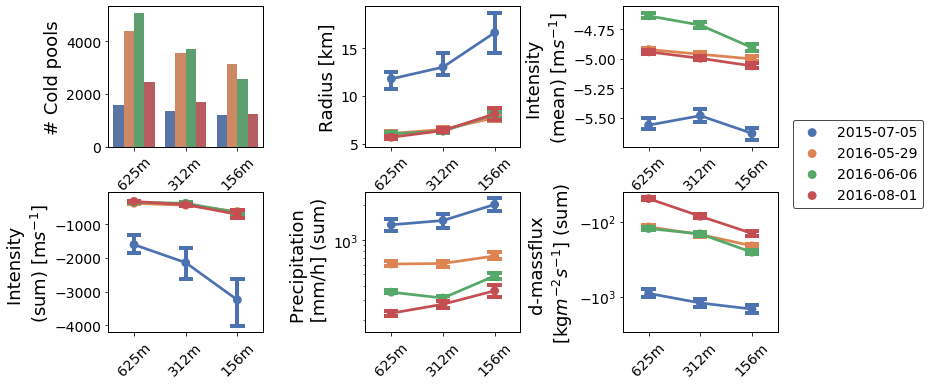

In [29]:
kws = dict(palette=secondary_colors, hue = 'date', capsize=.2, order =grid_ordered, errwidth=4, n_boot=1000)
default_estimator = np.mean

fig, axs = plt.subplots(2,3, sharex=False, squeeze=True, figsize=[12,6])
axs = axs.ravel()
i=0

egg = df.groupby(['grid_size', 'date'])['cp_radius'].value_counts().unstack('cp_radius')
egg['all'] = egg.sum(axis=1)
sns.barplot(data=egg.reset_index(), x='grid_size', y='all', ax=axs[i], estimator=np.median, **kws)
axs[i].set_ylabel('# Cold pools'); axs[i].set_xlabel('')
i+=1
sns.pointplot(data=df, x='grid_size', y='cp_radius', ax=axs[i], estimator=np.median,**kws)
axs[i].set_ylabel('Radius [km]'); axs[i].set_xlabel('')
i+=1
#sns.pointplot(data=df0[df0.age_norm==10], x='grid_size', y='age_max', ax=axs[i], estimator=np.mean,**kws)
#axs[i].set_ylabel('Life time [min] \n {mean}')
#i+=1
sns.pointplot(data=df, x='grid_size', y='intensity_mean_cp', ax=axs[i], estimator=np.median,**kws)#, hue='grid_size')#, order =age_bin_order)
axs[i].set_ylabel('Intensity \n(mean)'+r' [m$s^{-1}$]');  axs[i].set_xlabel('')
i+=1
sns.pointplot(data=df, x='grid_size', y='intensity_sum_cp', ax=axs[i], estimator=np.median,**kws)#, hue='grid_size')#, order =age_bin_order)
axs[i].set_ylabel('Intensity \n(sum)'+r' [m$s^{-1}$]');  axs[i].set_xlabel('')
#axs[i].set_yscale('symlog')
i+=1
sns.pointplot(data=df, x='grid_size', y='TOT_PREC_sum_cp', ax=axs[i], estimator=np.median,**kws)
axs[i].set_ylabel('Precipitation \n [mm/h] (sum)');
axs[i].set_yscale('log')
i+=1
sns.pointplot(data=df, x='grid_size', y='massflux_d_sum_cp', ax=axs[i],**kws)
axs[i].set_ylabel('d-massflux \n'+ r'[kg$m^{-2}s^{-1}$] (sum)')
axs[i].set_yscale('symlog')
axs[i].set_ylim([-3000,-40])

for i in [0, 1,2, 3,4,5]:
    axs[i].get_legend().remove()
    axs[i].xaxis.set_tick_params(rotation=45)
    axs[i].set_xlabel('')
#leg = axs[5].legend()
leg = axs[5].legend(loc='center left', bbox_to_anchor=(1.05, 1.2))
leg.get_frame().set_alpha(0.7)
#axs[5].remove()


fig.subplots_adjust( hspace=.32, wspace=0.66)
plt.savefig('../Figures/cold_pool_populations_dates.pdf')

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


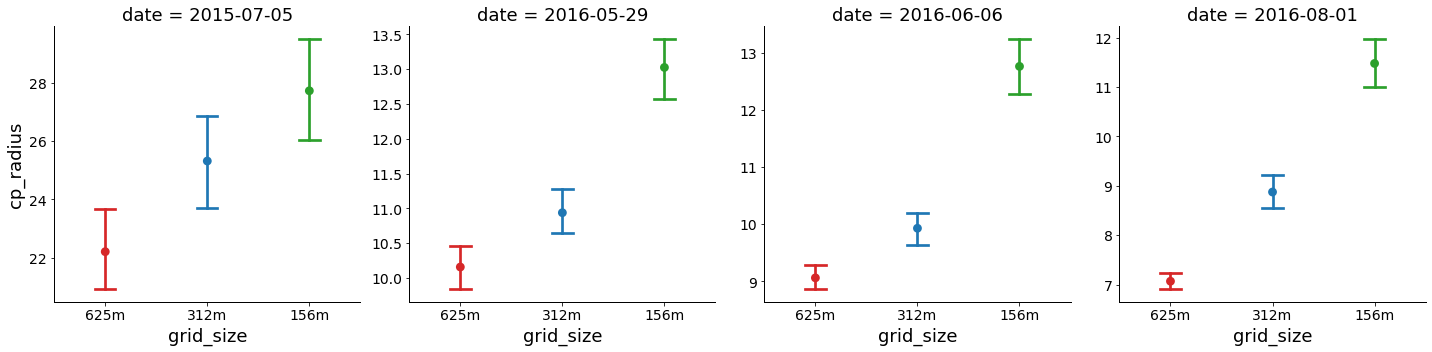

<Figure size 432x288 with 0 Axes>

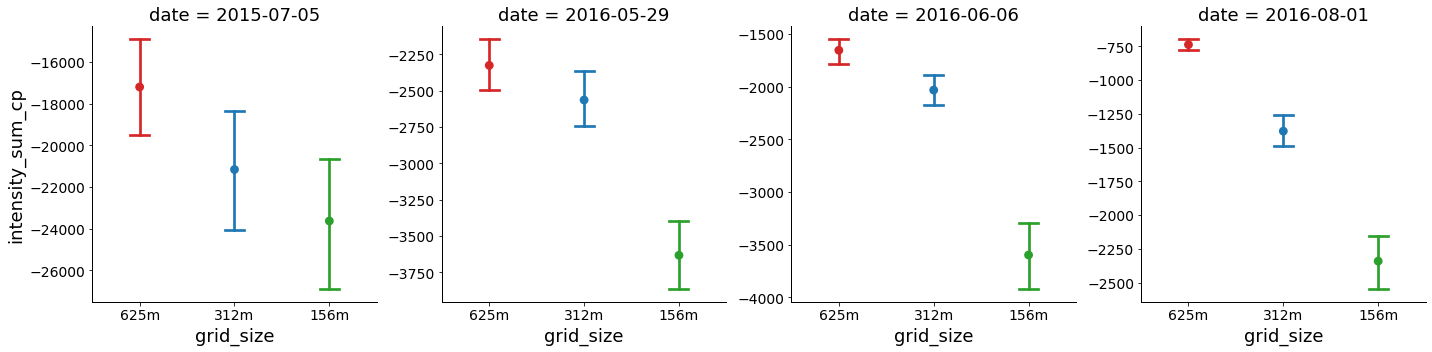

<Figure size 432x288 with 0 Axes>

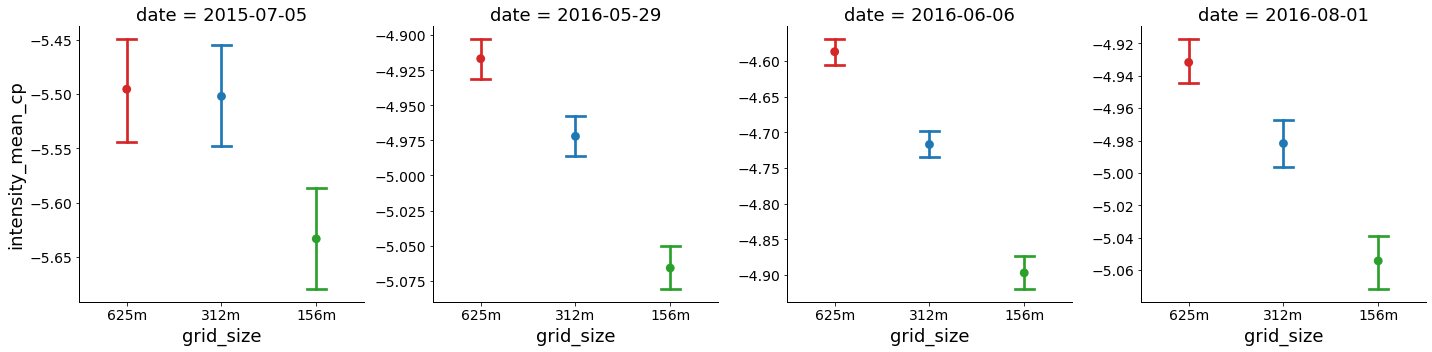

<Figure size 432x288 with 0 Axes>

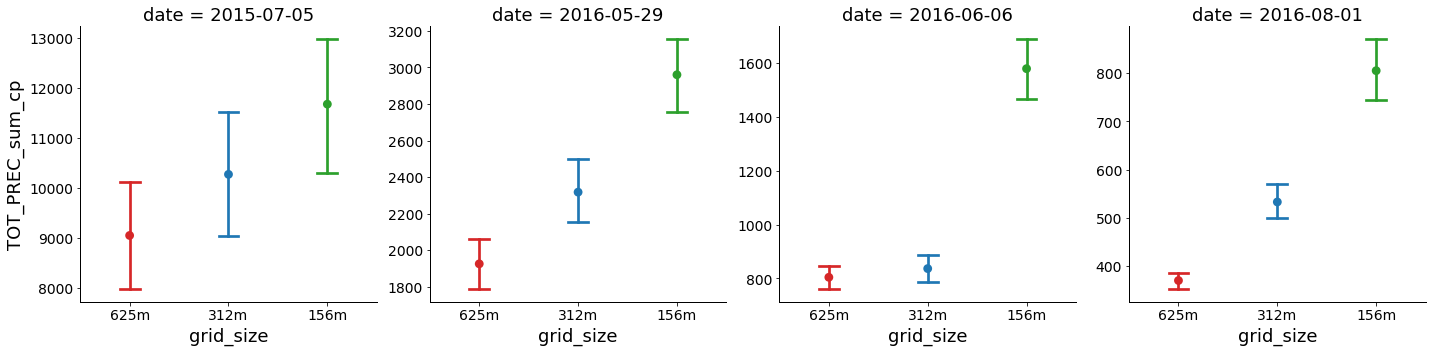

<Figure size 432x288 with 0 Axes>

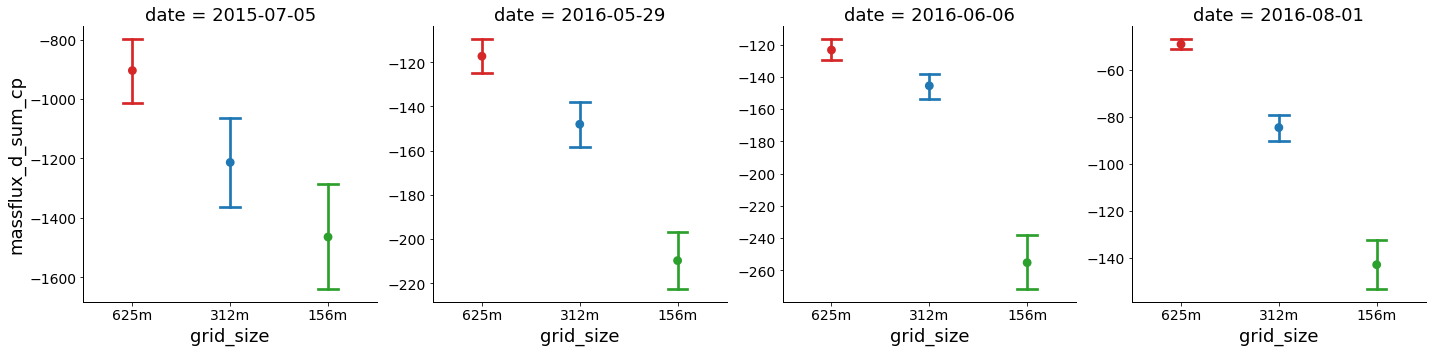

In [30]:
kws = dict( col='date', estimate=np.median, kind='point', sharey=False,
              order=grid_ordered, palette=grid_colors,  capsize=.2, error_width=2)
sns.catplot(data = df, x='grid_size', y='cp_radius', **kws)
plt.figure()
sns.catplot(data = df, x='grid_size', y='intensity_sum_cp', **kws)
plt.figure()
sns.catplot(data = df, x='grid_size', y='intensity_mean_cp', **kws)
plt.figure()
sns.catplot(data = df, x='grid_size', y='TOT_PREC_sum_cp', **kws)
plt.figure()
sns.catplot(data = df, x='grid_size', y='massflux_d_sum_cp', **kws)


### B) Differences in triggering 
#### B1) Overall differences in triggering

In [31]:
def set_variables_in_df_triggering(ds):
    
    df = ds.to_dataframe().reset_index()
    df['cp_radius'] = np.sqrt(df['n_gridpoints_cp']/np.pi)*1.22
    df['size_category'] =df.cp_radius
    df['size_category'][df.cp_radius>40]=40
    df['size_category'] = df.size_category//5*5
    df['wa_category'] = df.wa_95_cpe//.5
    shell = df['intensity_mean_cp']
    df['intensity_category']=np.nan
    df.loc[shell<-6.5,'intensity_category'] ='<-6.5'
    df.loc[shell>-6.5,'intensity_category'] ='>-6.5'
    df.loc[shell>-6.,'intensity_category'] ='>-6'
    df.loc[shell>-5.5,'intensity_category'] ='>-5.5'
    df.loc[shell>-5,'intensity_category'] ='>-5'
    df.loc[shell>-4.5,'intensity_category'] ='>-4.5'
    df.loc[shell>-4,'intensity_category'] ='>-4'

    df['forcing_type'] = df.date.copy()
    df.loc[df.date=='2015-07-05','forcing_type']='strong forcing'
    df.loc[df.date=='2016-05-29','forcing_type']='strong forcing'
    df.loc[df.date=='2016-06-06','forcing_type']='weak forcing'
    df.loc[df.date=='2016-08-01','forcing_type']='weak forcing'
    
    return df

In [32]:
df = set_variables_in_df_triggering(ds)
df.columns

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['cp_index', 'grid_size', 'time', 'intensity_mean_cp',
       'intensity_sum_cp', 'buoyancy_CPtop_mean_cp', 'n_gridpoints_cp',
       'n_triggering_cp', 'TOT_PREC_mean_cp', 'TOT_PREC_sum_cp',
       'massflux_d_mean_cp', 'massflux_d_sum_cp', 'wa_5_cp',
       'n_gridpoints_cpe', 'n_triggering_cpe', 'wa_95_cpe',
       'massflux_u_mean_cpe', 'massflux_u_sum_cpe', 'buoyancy_CPtop_95_cpe',
       'p_ci_cp', 'p_ci_cpe', 'mask', 'pctl_stats', 'quantile', 'date',
       'time_hhmm', 'age', 'age_max', 'cp_radius', 'growth', 'strengthening',
       'growth_mflux', 'size_category', 'wa_category', 'intensity_category',
       'forcing_type'],
      dtype='object')

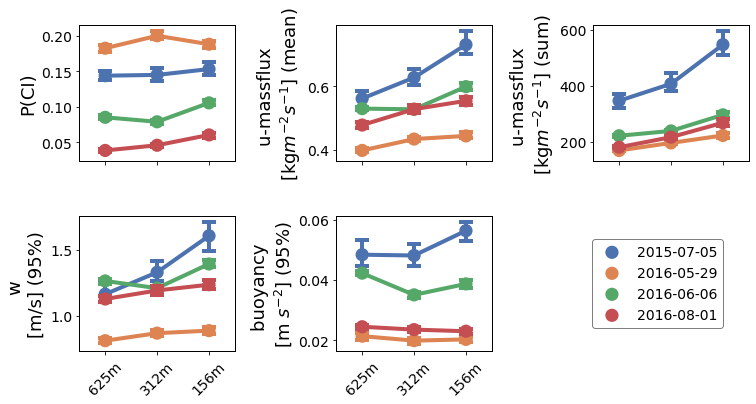

In [33]:
plot_kws =dict(x ='grid_size', join=True, width=5, hue='date', estimator=np.median,
                palette = secondary_colors, order=grid_ordered, 
                capsize=.2, errwidth=4, scale=1.5)



fig, axs = plt.subplots(2,3, sharex=True, squeeze=True, figsize=[12,6])
axs = axs.ravel()

i = 0
sns.pointplot(data=df, y='p_ci_cpe', ax=axs[i], **plot_kws)
axs[i].set_ylabel('P(CI)')

i+=1
sns.pointplot(data=df, y='massflux_u_mean_cpe', ax=axs[i],**plot_kws)
axs[i].set_ylabel('u-massflux \n'+ r'[kg$m^{-2}s^{-1}$] (mean)')
i+=1
sns.pointplot(data=df, y='massflux_u_sum_cpe', ax=axs[i],**plot_kws)
axs[i].set_ylabel('u-massflux \n'+ r'[kg$m^{-2}s^{-1}$] (sum)')
i+=1

sns.pointplot(data=df, y='wa_95_cpe',ax=axs[i], **plot_kws)
axs[i].set_ylabel('w \n[m/s] (95%)')
i+=1
sns.pointplot(data=df, y='buoyancy_CPtop_95_cpe',ax=axs[i], **plot_kws)
axs[i].set_ylabel('buoyancy \n'+ r'[m $s^{-2}$] (95%)')

for i in range(0,5):
    axs[i].get_legend().remove()
    axs[i].xaxis.set_tick_params(rotation=45)
    axs[i].set_xlabel('')
axs[5].remove()
leg = axs[4].legend(loc='center left', bbox_to_anchor=(1.6, 0.5))
#leg = axs[3].legend(loc='upper left')
leg.get_frame().set_alpha(0.5)
fig.subplots_adjust(#left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=.4, wspace=.65)

fig.savefig('../Figures/general_triggering_dates.pdf')

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


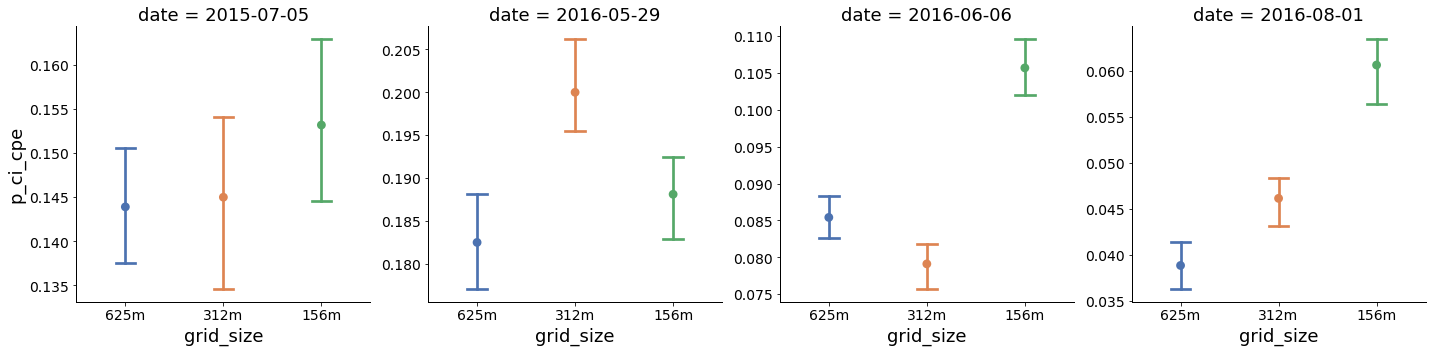

<Figure size 432x288 with 0 Axes>

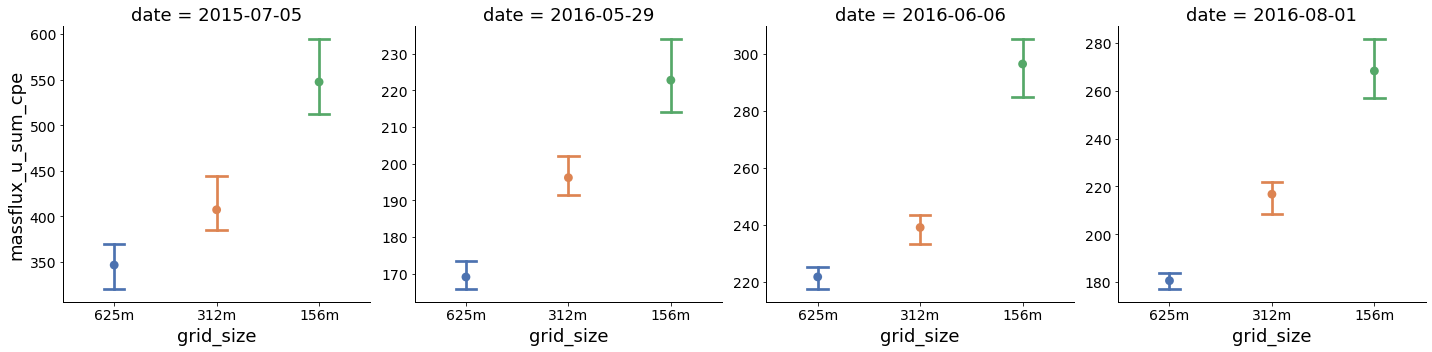

<Figure size 432x288 with 0 Axes>

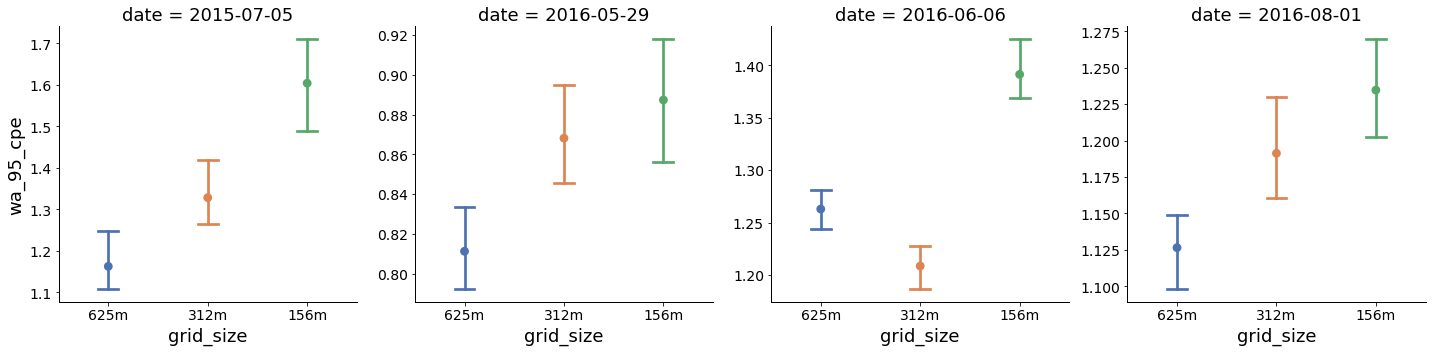

<Figure size 432x288 with 0 Axes>

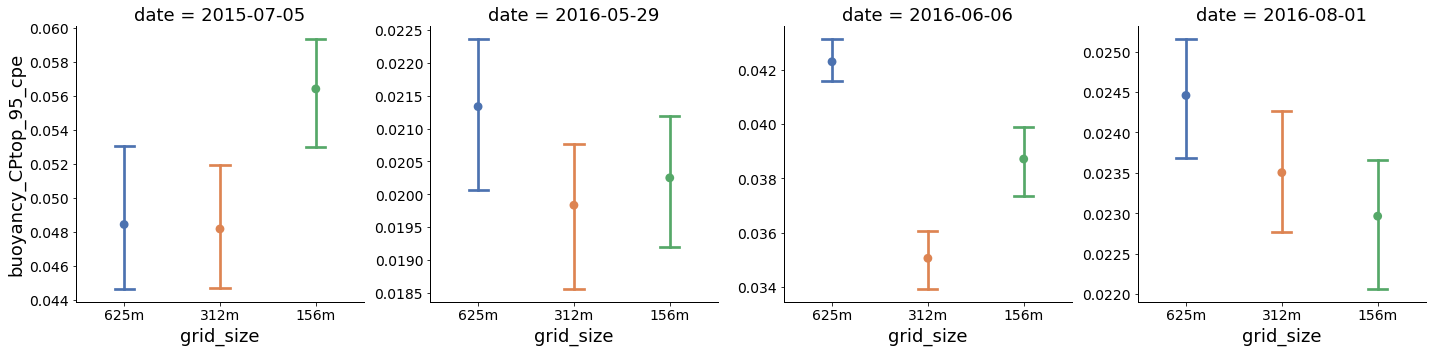

In [34]:
kws = dict( col='date', estimator=np.median, kind='point', sharey=False,
              order=grid_ordered, palette=secondary_colors,  capsize=.2, error_width=2)
sns.catplot(data = df, x='grid_size', y='p_ci_cpe', **kws)

plt.figure()
sns.catplot(data = df, x='grid_size', y='massflux_u_sum_cpe', **kws)

plt.figure()
sns.catplot(data = df, x='grid_size', y='wa_95_cpe', **kws)

plt.figure()
sns.catplot(data = df, x='grid_size', y='buoyancy_CPtop_95_cpe', **kws)

#### B2) Relationships


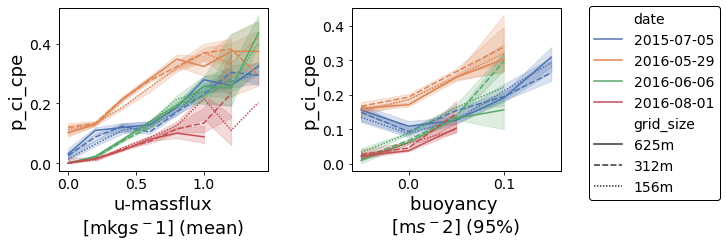

In [35]:
fig, axs = plt.subplots(1,2, sharex=False, squeeze=True, figsize=[9,3])
axs = axs.ravel()


plot_kws = dict(style='grid_size',palette = secondary_colors[:4], hue ='date', #capsize=0.2,
                style_order=grid_ordered, estimator=np.median,n_boot=100)

i = 0
df['mflux_cat'] = df.massflux_u_mean_cpe//.2*.2
df.loc[df.mflux_cat>1.4, 'mflux_cat'] = 1.4
#df.loc[df.mflux_cat<6, 'mflux_cat'] = 6
sns.lineplot(data=df,x='mflux_cat',y='p_ci_cpe', ax =axs[i],   **plot_kws)# order =wa_category_order,)
axs[i].set_xlabel('u-massflux\n'+ r'[mkg$s^-1$] (mean)')


i +=1
df['buoyancy_cat'] = (df.buoyancy_CPtop_95_cpe//.05*.05).round(decimals=2)
df.loc[df.buoyancy_cat>.15, 'buoyancy_cat'] = .15
df.loc[df.buoyancy_cat<-.05, 'buoyancy_cat'] = -.05

sns.lineplot(data=df,x='buoyancy_cat',y='p_ci_cpe', ax =axs[i], **plot_kws)
axs[i].set_xlabel('buoyancy \n' +r'[m$s^-2$] (95%)')

for i in range(0,2):
    axs[i].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.1, 1.05))
#leg.get_frame().set_alpha(.4)
fig.subplots_adjust(#left=0.08, right=0.98, bottom=0.05, top=0.9,
                    wspace=.4)
    

plt.savefig('../Figures/wa_hus_b_dependent_p_ci_dates.pdf')

FigureCanvasNbAgg()

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


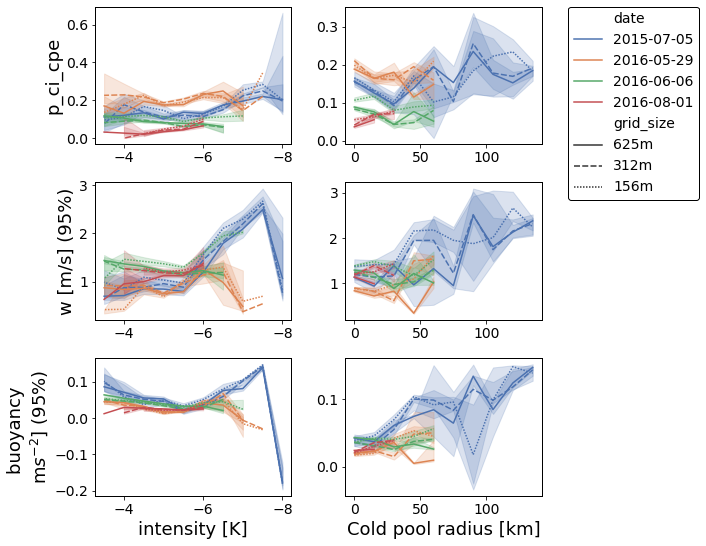

In [36]:
%matplotlib widget
fig, axs = plt.subplots(3,2, sharex=False, sharey=False, squeeze=True, figsize=[8,9])
axs = axs.ravel()


plot_kws = dict(style='grid_size', palette = secondary_colors[:4], hue = 'date',
                style_order=grid_ordered, estimator=np.median)
intensity_cat_order= ['>-4', '>-4.5', '>-5', '>-5.5', '>-6', '>-6.5', '<-6.5']
df['intensity_category'] = (df.intensity_mean_cp//.5*.5).round(1)
df.loc[df.intensity_category<-8, 'intensity_category'] = -8
df.loc[df.intensity_category>-3.5, 'intensity_category'] = -3.5
i = 0
sns.lineplot(data=df,x='intensity_category',y='p_ci_cpe', ax =axs[i], **plot_kws)
axs[i].invert_xaxis()
axs[i].set_xlabel('')
axs[i].set_ylabel('p_ci_cpe')

i +=1
df['radius_cat'] = df.cp_radius//15*15
sns.lineplot(data=df,x='radius_cat',y='p_ci_cpe', ax =axs[i], **plot_kws)
axs[i].set_xlabel('')
axs[i].set_ylabel('')

i +=1
sns.lineplot(data=df,x='intensity_category',y='wa_95_cpe', ax =axs[i], **plot_kws)
axs[i].invert_xaxis()
axs[i].set_xlabel('')
axs[i].set_ylabel('w [m/s] (95%)')

i +=1
sns.lineplot(data=df,x='radius_cat',y='wa_95_cpe', ax =axs[i], **plot_kws)
axs[i].set_xlabel('')
axs[i].set_ylabel('')

i +=1
sns.lineplot(data=df,x='intensity_category',y='buoyancy_CPtop_95_cpe', ax =axs[i], **plot_kws)
axs[i].invert_xaxis()
axs[i].set_ylabel('buoyancy \n'+r'm$s^{-2}$] (95%)')
axs[i].set_xlabel('intensity [K]')

i +=1
sns.lineplot(data=df,x='radius_cat',y='buoyancy_CPtop_95_cpe', ax =axs[i], **plot_kws)
axs[i].set_ylabel('')
axs[i].set_xlabel('Cold pool radius [km]')

for i in range(0,6):
    axs[i].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.1, 1.05))
    

fig.subplots_adjust(hspace=.275, wspace=.275)
    

FigureCanvasNbAgg()

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


FigureCanvasNbAgg()

FigureCanvasNbAgg()

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


FigureCanvasNbAgg()

FigureCanvasNbAgg()

/home/m/M.Hirt/.conda/envs/my_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


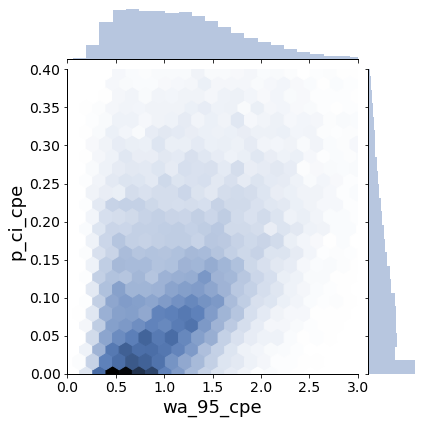

<Figure size 432x288 with 0 Axes>

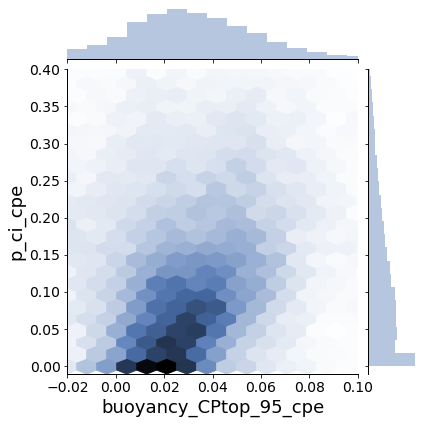

<Figure size 432x288 with 0 Axes>

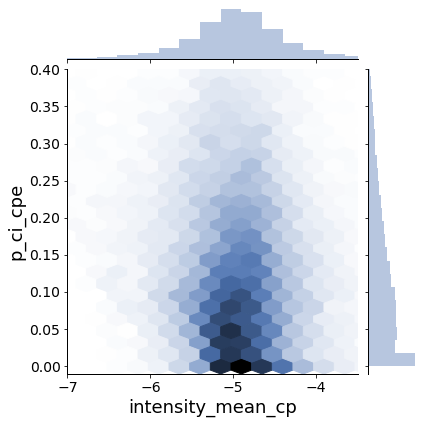

In [37]:
ax = sns.jointplot( "wa_95_cpe", 'p_ci_cpe', data=df, kind="hex", xlim=[0,3], ylim=[0,0.4])
plt.figure()
sns.jointplot( "buoyancy_CPtop_95_cpe", 'p_ci_cpe', data=df, kind="hex", xlim=[-.02,.1], ylim=[-0.01,0.4])
plt.figure()
sns.jointplot( "intensity_mean_cp", 'p_ci_cpe', data=df, kind="hex", xlim=[-7,-3.5], ylim=[-0.01,0.4])
